# Assignment

In this assignment, you keep working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

In [23]:
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [24]:
student_df.info()
student_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


There are no nulls to handle, but I do know I need to winsorize the scores from previous modules

In [25]:
student_df['winz_math_score'] = winsorize(student_df['math score'], (.05, .05))
student_df['winz_reading_score'] = winsorize(student_df['reading score'], (.05,0))
student_df['winz_writing_score'] = winsorize(student_df['writing score'], (.05,0))

### 1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?


In [26]:
# Let's look at gender first
student_df.groupby('gender').mean()[['winz_math_score', 'winz_reading_score', 'winz_writing_score']]

,winz_math_score,winz_reading_score,winz_writing_score
gender,,,
female,64.086873,72.882239,72.795367
male,68.587137,65.879668,63.765560


It does appear there's a difference in grades. Scores are higher for boys in math and scores for girls are higher in reading and writing. Let's visualize these:

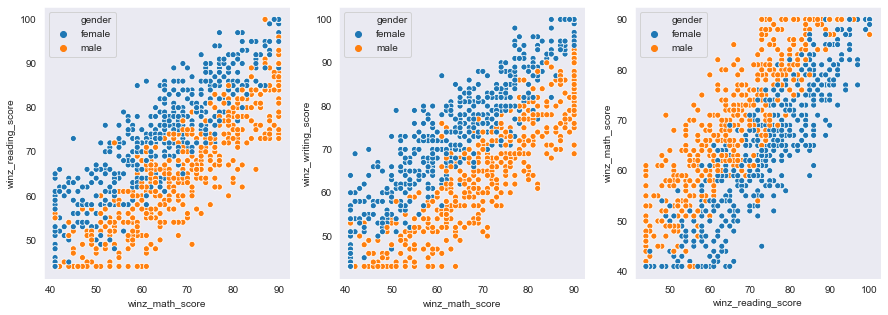

In [27]:
sns.set_style('dark')
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(x='winz_math_score', y='winz_reading_score', data=student_df, hue='gender')

plt.subplot(1,3,2)
sns.scatterplot(x='winz_math_score', y='winz_writing_score', data=student_df, hue='gender')

plt.subplot(1,3,3)
sns.scatterplot(x='winz_reading_score', y='winz_math_score', data=student_df, hue='gender');

In [28]:
# Running a t-test to verify what we're seeing:
stats.ttest_ind(
        student_df[student_df['gender']=='female'][['winz_math_score', 'winz_reading_score', 'winz_writing_score']],
        student_df[student_df['gender']=='male'][['winz_math_score', 'winz_reading_score', 'winz_writing_score']]
)

Ttest_indResult(statistic=array([-5.25427965,  8.2568527 , 10.48080402]), pvalue=array([1.81674462e-07, 4.70783430e-16, 1.86607339e-24]))

All results are indeed significant with pvalue < .01

Now let's look at ethnicities:

In [29]:
student_df.groupby('race/ethnicity').mean()[['winz_math_score', 'winz_reading_score', 'winz_writing_score']]

,winz_math_score,winz_reading_score,winz_writing_score
race/ethnicity,,,
group A,61.741573,65.179775,63.168539
group B,64.136842,67.836842,66.326316
group C,64.786834,69.454545,68.194357
group D,67.438931,70.255725,70.339695
group E,73.135714,73.242857,71.685714


Group E looks like it might be highest overall. Let's plot and run some tests

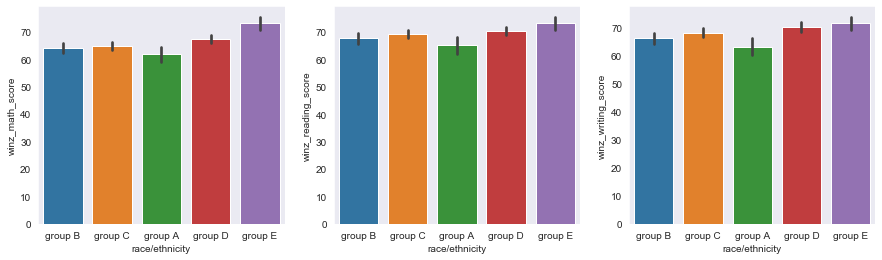

In [30]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.barplot(student_df['race/ethnicity'], student_df['winz_math_score'])

plt.subplot(1,3,2)
sns.barplot(student_df['race/ethnicity'], student_df['winz_reading_score'])

plt.subplot(1,3,3)
sns.barplot(student_df['race/ethnicity'], student_df['winz_writing_score'])

In [31]:
ethnicities = student_df['race/ethnicity'].unique()

for col in ['winz_math_score','winz_reading_score', 'winz_writing_score']:
    print('_'*75)
    print(f'{col}')
    print('-'*75)

    for i in range(0,len(ethnicities)):
        for j in range(i+1,len(ethnicities)):
            print(f't-test between {ethnicities[i]} and {ethnicities[j]}')
            print(stats.ttest_ind(
                student_df[student_df['race/ethnicity']==ethnicities[i]][col],
                 student_df[student_df['race/ethnicity']==ethnicities[j]][col]))

___________________________________________________________________________
winz_math_score
---------------------------------------------------------------------------
t-test between group B and group C
Ttest_indResult(statistic=-0.5293087551780653, pvalue=0.5968229553360528)
t-test between group B and group A
Ttest_indResult(statistic=1.3829757736492614, pvalue=0.16778605652140366)
t-test between group B and group D
Ttest_indResult(statistic=-2.6202073884484216, pvalue=0.009084776596308271)
t-test between group B and group E
Ttest_indResult(statistic=-5.918727210471441, pvalue=8.172166741563633e-09)
t-test between group C and group A
Ttest_indResult(statistic=1.9042903864203358, pvalue=0.05757895623366425)
t-test between group C and group D
Ttest_indResult(statistic=-2.4131923874228853, pvalue=0.01612300872219802)
t-test between group C and group E
Ttest_indResult(statistic=-6.110687018511012, pvalue=2.126366623552467e-09)
t-test between group A and group D
Ttest_indResult(statistic=-

There are significant differeneces here mostly between groups of A,B,C to D,E. There is fewer significant differences within those two groups

In [41]:
# Now let's look at parental level of education
student_df.groupby('parental level of education').mean()[['winz_math_score', 'winz_reading_score', 'winz_writing_score']]

,winz_math_score,winz_reading_score,winz_writing_score
parental level of education,,,
associate's degree,67.648649,71.058559,70.013514
bachelor's degree,69.059322,73.059322,73.466102
high school,62.775510,65.234694,63.066327
master's degree,69.576271,75.406780,75.677966
some college,67.159292,69.774336,69.283186
some high school,64.256983,67.636872,65.625698


In [44]:
# Make smaller df of parental level and melt
parents_level = student_df[['parental level of education','winz_math_score','winz_reading_score', 'winz_writing_score']]

melt_parent_level = parents_level.melt(
            id_vars='parental level of education',
            var_name='test',
            value_name='score')

melt_parent_level

,parental level of education,test,score
0,bachelor's degree,winz_math_score,72
1,some college,winz_math_score,69
2,master's degree,winz_math_score,90
3,associate's degree,winz_math_score,47
4,some college,winz_math_score,76
...,...,...,...
2995,master's degree,winz_writing_score,95
2996,high school,winz_writing_score,55
2997,high school,winz_writing_score,65
2998,some college,winz_writing_score,77


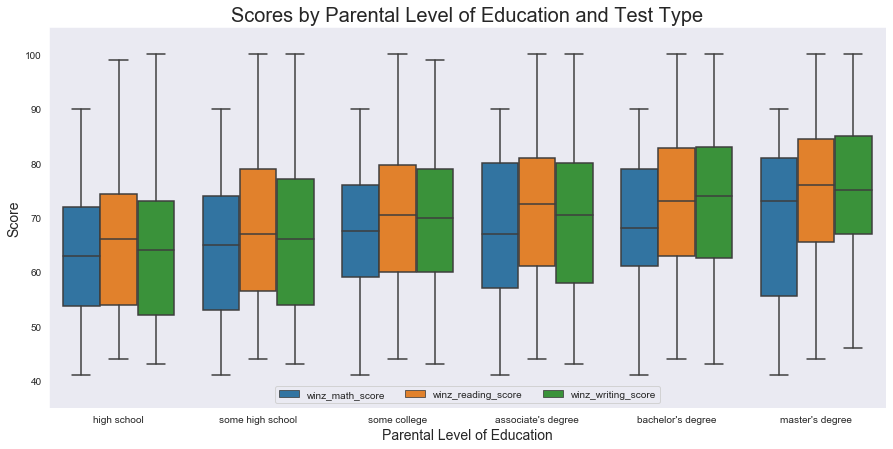

In [80]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='parental level of education', y='score', data=melt_parent_level, hue='test', 
            order=('high school', 'some high school', 'some college', 
                   "associate's degree", "bachelor's degree", "master's degree"))
ax.set(ylim=(35, 105));
ax.legend(loc=8, ncol=3)
ax.set_xlabel('Parental Level of Education', size=14)
ax.set_ylabel('Score', size=14)
_=ax.set_title('Scores by Parental Level of Education and Test Type', size=20)

It does appear as though Master's Degree is higher than all others and next is Bachelor's Degree. Let's look at the t-test

In [52]:
grouped_melt_parent = melt_parent_level.groupby('parental level of education').mean()['score']
grouped_melt_parent

parental level of education
associate's degree    69.573574
bachelor's degree     71.861582
high school           63.692177
master's degree       73.553672
some college          68.738938
some high school      65.839851
Name: score, dtype: float64

In [97]:
parent_level = student_df['parental level of education'].unique()

for col in ['winz_math_score','winz_reading_score', 'winz_writing_score']:
    print('_'*75)
    print(f'{col}')
    print('-'*75)

    for i in range(0,len(parent_level)):
        for j in range(i+1,len(parent_level)):
            print(f't-test between {parent_level[i]} and {parent_level[j]}')
            print(stats.ttest_ind(
                student_df[student_df['parental level of education']==parent_level[i]][col],
                 student_df[student_df['parental level of education']==parent_level[j]][col]))

___________________________________________________________________________
winz_math_score
---------------------------------------------------------------------------
t-test between bachelor's degree and some college
Ttest_indResult(statistic=1.275258959359219, pvalue=0.20308319102489178)
t-test between bachelor's degree and master's degree
Ttest_indResult(statistic=-0.2312326328275237, pvalue=0.8174042123309904)
t-test between bachelor's degree and associate's degree
Ttest_indResult(statistic=0.8816318529315292, pvalue=0.37860243606953703)
t-test between bachelor's degree and high school
Ttest_indResult(statistic=4.09735877489629, pvalue=5.332233549479552e-05)
t-test between bachelor's degree and some high school
Ttest_indResult(statistic=2.952008208233746, pvalue=0.0034106983323036752)
t-test between some college and master's degree
Ttest_indResult(statistic=-1.246403456966046, pvalue=0.21364702517501)
t-test between some college and associate's degree
Ttest_indResult(statistic=-0.3

There are some significant values in a lot of areas but mainly in the separation between parent's level of education completing bachelors and above with high school and below

### 2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?


Let's look at a smaller section of the dataframe and look at the winsorized distributions

In [32]:
# Smaller section of the df with just lunch and winzed scores
lunch_scores = student_df[['lunch','winz_math_score','winz_reading_score', 'winz_writing_score']]

lunch_scores

,lunch,winz_math_score,winz_reading_score,winz_writing_score
0,standard,72,72,74
1,standard,69,90,88
2,standard,90,95,93
3,free/reduced,47,57,44
4,standard,76,78,75
...,...,...,...,...
995,standard,88,99,95
996,free/reduced,62,55,55
997,free/reduced,59,71,65
998,standard,68,78,77


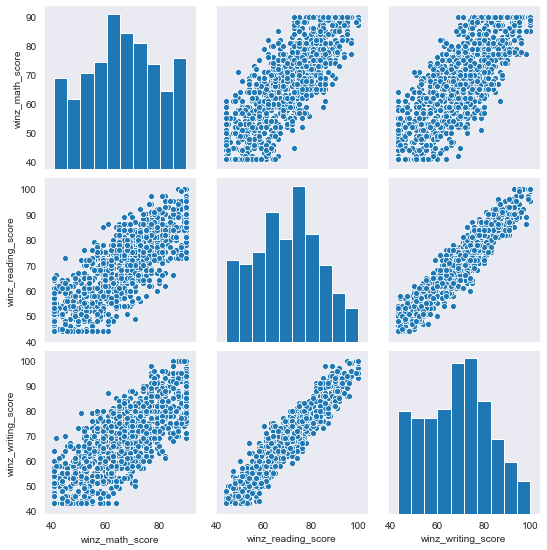

In [33]:
sns.pairplot(lunch_scores);

Distributions appear normal (and reading and writing seem to be highly correlated, which will be discussed later), but let's veryify the distributions are normal via test:

In [34]:
print(stats.describe(lunch_scores['winz_math_score']))
print(stats.describe(lunch_scores['winz_reading_score']))
print(stats.describe(lunch_scores['winz_writing_score']))

DescribeResult(nobs=1000, minmax=(41, 90), mean=66.256, variance=188.0365005005005, skewness=-0.059020352729665375, kurtosis=-0.8400832071970443)
DescribeResult(nobs=1000, minmax=(44, 100), mean=69.507, variance=191.6576086086086, skewness=0.017923333655369703, kurtosis=-0.6689787991760596)
DescribeResult(nobs=1000, minmax=(43, 100), mean=68.443, variance=205.5222732732733, skewness=0.00919118933188806, kurtosis=-0.705152957679767)


All seem to be within acceptable ranges. Let's melt the dataframe to make a better boxplot:

In [35]:
melt_lunch_scores = lunch_scores.melt(
            id_vars='lunch',
            var_name='test',
            value_name='score',)

melt_lunch_scores

,lunch,test,score
0,standard,winz_math_score,72
1,standard,winz_math_score,69
2,standard,winz_math_score,90
3,free/reduced,winz_math_score,47
4,standard,winz_math_score,76
...,...,...,...
2995,standard,winz_writing_score,95
2996,free/reduced,winz_writing_score,55
2997,free/reduced,winz_writing_score,65
2998,standard,winz_writing_score,77


Let's look at these distributions:

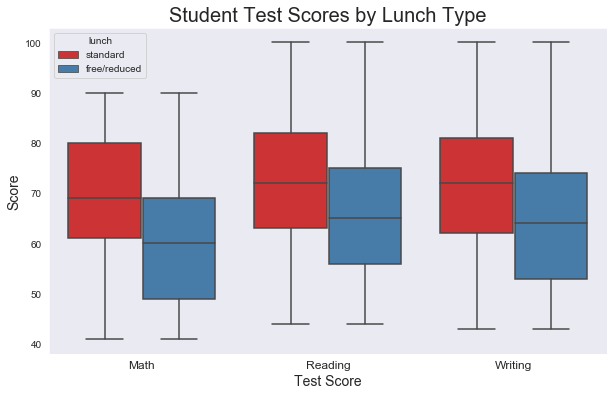

In [36]:
sns.set_style('dark')

plt.figure(figsize=(10,6))

sns.boxplot(x='test', y='score', data=melt_lunch_scores, hue='lunch', palette='Set1')

plt.title('Student Test Scores by Lunch Type', fontsize=20)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Test Score', fontsize=14)
plt.xticks(ticks=np.arange(0,3), labels=['Math', 'Reading', 'Writing'], fontsize=12);

There appears to be a difference in averages over all scores by lunch type. 

In [37]:
lunches=lunch_scores['lunch'].unique()

for col in ['winz_math_score','winz_reading_score', 'winz_writing_score']:
    print('_'*75)
    print(f'{col}')
    print('-'*75)

    for i in range(0,len(lunches)):
        for j in range(i+1,len(lunches)):
            print(f't-test between {lunches[i]} and {lunches[j]}')
            print(stats.ttest_ind(
                lunch_scores[lunch_scores['lunch']==lunches[i]][col],
                 lunch_scores[lunch_scores['lunch']==lunches[j]][col]))
        
    

___________________________________________________________________________
winz_math_score
---------------------------------------------------------------------------
t-test between standard and free/reduced
Ttest_indResult(statistic=11.665706432421889, pvalue=1.4349082385804919e-29)
___________________________________________________________________________
winz_reading_score
---------------------------------------------------------------------------
t-test between standard and free/reduced
Ttest_indResult(statistic=7.229107552822186, pvalue=9.65880540245068e-13)
___________________________________________________________________________
winz_writing_score
---------------------------------------------------------------------------
t-test between standard and free/reduced
Ttest_indResult(statistic=7.763281955135954, pvalue=2.043591547232422e-14)


The differences in groups are significant. 

Reasons: It is likely that students in the free/reduced lunch plan are lower income and people with higher incomes tend to have more resources to do better

### 3. Does the test preparation course seem to have an effect on the exam performances?


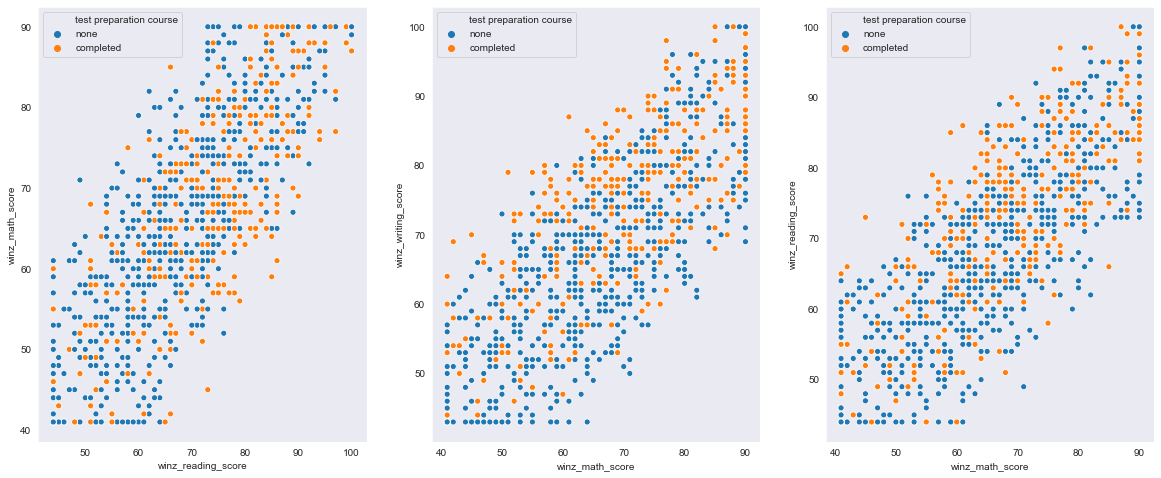

In [82]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.scatterplot(x='winz_reading_score', y='winz_math_score', data=student_df, hue='test preparation course')

plt.subplot(1,3,2)
sns.scatterplot(x='winz_math_score', y='winz_writing_score', data=student_df, hue='test preparation course')

plt.subplot(1,3,3)
_=sns.scatterplot(x='winz_math_score', y='winz_reading_score', data=student_df, hue='test preparation course')


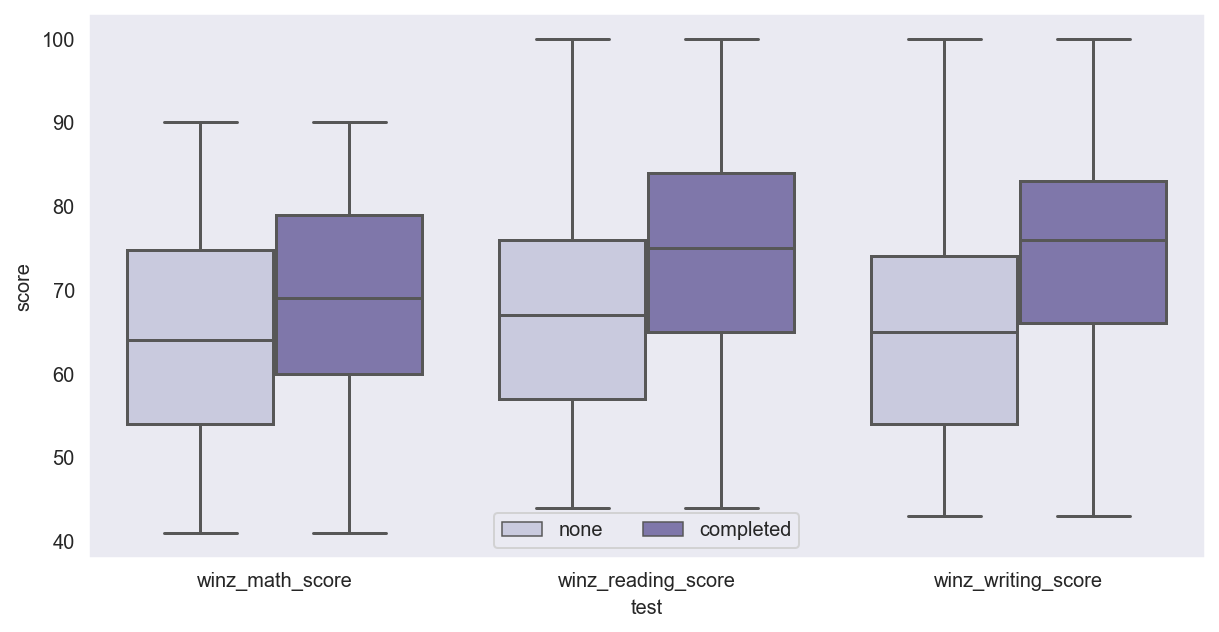

In [95]:
test_prep = student_df[['test preparation course', 'winz_math_score','winz_reading_score', 'winz_writing_score']]
melt_test_prep = test_prep.melt(
            id_vars='test preparation course',
            var_name='test',
            value_name='score')

plt.figure(figsize=(10,5))
ax3 = sns.boxplot(x='test', y='score', data=melt_test_prep, hue='test preparation course', palette='Purples')
_ = ax3.legend(loc=8, ncol=2)


The scatterplot wasn't too clear, but the boxplot seems to show some effectiveness of test prep course. Let's test to find out:

In [81]:
student_df.groupby('test preparation course').mean()[['winz_math_score', 'winz_reading_score', 'winz_writing_score']]

,winz_math_score,winz_reading_score,winz_writing_score
test preparation course,,,
completed,69.413408,73.955307,74.472067
none,64.495327,67.026480,65.080997


In [94]:
for col in ['winz_math_score', 'winz_reading_score', 'winz_writing_score']:
    print('_'*75)
    print(f'T-test for completed v. no test prep for test: {col}')
    
    print(stats.ttest_ind(
        student_df[student_df['test preparation course']=='completed'][col],
        student_df[student_df['test preparation course']=='none'][col]
    ))
    print('_'*75)

___________________________________________________________________________
T-test for completed v. no test prep for test: winz_math_score
Ttest_indResult(statistic=5.516826930225408, pvalue=4.3979289425100825e-08)
___________________________________________________________________________
___________________________________________________________________________
T-test for completed v. no test prep for test: winz_reading_score
Ttest_indResult(statistic=7.812273971873327, pvalue=1.4180597480852587e-14)
___________________________________________________________________________
___________________________________________________________________________
T-test for completed v. no test prep for test: winz_writing_score
Ttest_indResult(statistic=10.455585268650667, pvalue=2.372253916694949e-24)
___________________________________________________________________________


Completing the test prep does seem to raise test scores as the results are significant

### 4. Which 2 exam scores are most correlated with each other?

In [39]:
# using the lunch df since the only continuous variables are the winsorized columns
scores_corr = lunch_scores.corr()

scores_corr

,winz_math_score,winz_reading_score,winz_writing_score
winz_math_score,1.000000,0.806335,0.786439
winz_reading_score,0.806335,1.000000,0.951425
winz_writing_score,0.786439,0.951425,1.000000


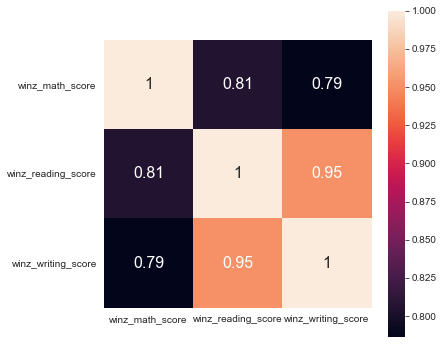

In [40]:
plt.figure(figsize=(6,6))

sns.heatmap(scores_corr, annot=True, square=True, annot_kws={"size": 16});

At 0.95, reading and writing are the most correlated